<a href="https://colab.research.google.com/github/fnqkfnqk/ACD/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.10.12


In [ ]:
!wget https://www.python.org/ftp/python/3.6.9/Python-3.6.9.tgz
!tar xvfz Python-3.6.9.tgz
!Python-3.6.9/configure
!make
!sudo make install

In [ ]:
!python --version

Python 3.6.9


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow.compat.v1 as tf

print(tf.__version__)

2.13.0


In [2]:
!unzip -qq "/content/drive/MyDrive/졸업작품/자율 주행 모델/data3.zip"

In [3]:
import os
import random
import fnmatch
import datetime
import pickle

#data processing
import numpy as np
np.set_printoptions(formatter={'float_kind' :lambda x: "%.4f" % x})

import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

#tensorflow
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

#print(f'tf.__version__:{tf.__version__}')
#print(f' .keras.__version__:{tensorflow.keras.__version__}')

#sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

#imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
%matplotlib inline
from PIL import Image

image_path: /content/data3/data_00731_045.png
steering_Angle: 45


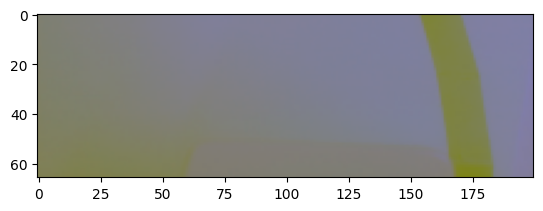

In [4]:
# 데이터 불러오기
data_dir = '/content/data3'
file_list = os.listdir(data_dir)
image_paths = []
steering_angles = []
pattern = '*.png'

for filename in file_list:
  if fnmatch.fnmatch(filename, pattern):
    image_paths.append(os.path.join(data_dir, filename))
    angle = int(filename[-7:-4])
    steering_angles.append(angle)

image_index = 20
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index])
print("steering_Angle: %s" % steering_angles[image_index])

df = pd.DataFrame()
df['ImagePath'] = image_paths
df['Angle'] = steering_angles

(array([979.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 827.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        932.0000]),
 array([45.0000, 48.6000, 52.2000, 55.8000, 59.4000, 63.0000, 66.6000,
        70.2000, 73.8000, 77.4000, 81.0000, 84.6000, 88.2000, 91.8000,
        95.4000, 99.0000, 102.6000, 106.2000, 109.8000, 113.4000, 117.0000,
        120.6000, 124.2000, 127.8000, 131.4000, 135.0000]),
 <BarContainer object of 25 artists>)

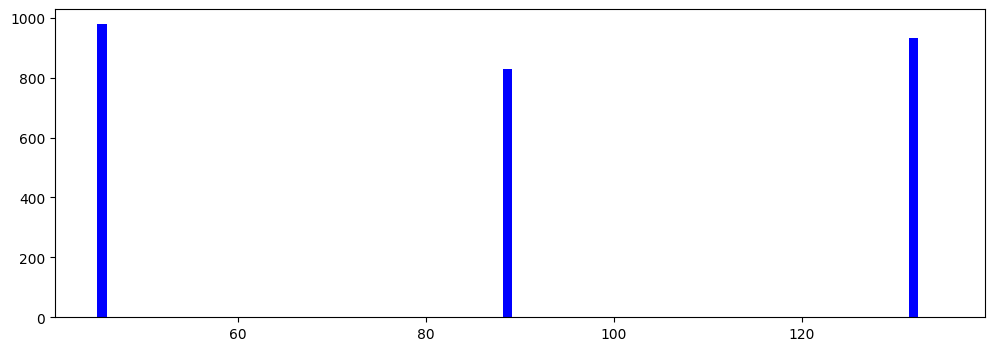

In [5]:
# 조향각 분포 확인
num_of_bins=25
hist, bins = np.histogram(df['Angle'], num_of_bins)

fig, axes = plt.subplots(1,1, figsize=(12,4))
axes.hist(df['Angle'],bins=num_of_bins, width=1, color='blue')

In [6]:
# 학습 데이터와 검증 데이터 분리
x_train, x_valid, y_train, y_valid = train_test_split(image_paths, steering_angles, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(x_train), len(x_valid)))

Training data: 2190
Validation data: 548


Text(0.5, 1.0, 'Validation Data')

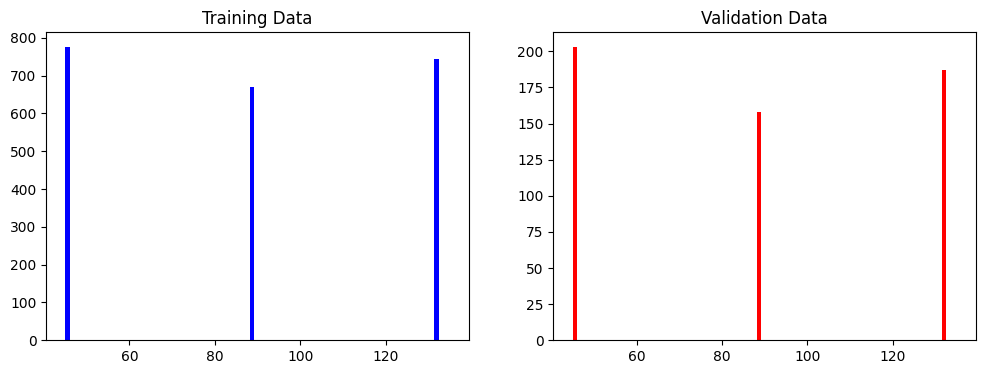

In [7]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
axes[0].hist(y_train, bins=num_of_bins, width=1, color='blue')
axes[0].set_title('Training Data')

axes[1].hist(y_valid, bins=num_of_bins, width=1, color='red')
axes[1].set_title('Validation Data')

In [8]:
#이미지 읽기 및 정규화
def imread(image_path):
  image = cv2.imread(image_path)
  return image

def image_preprocessing(image):
  image = image / 255
  return image

Text(0.5, 1.0, 'processed')

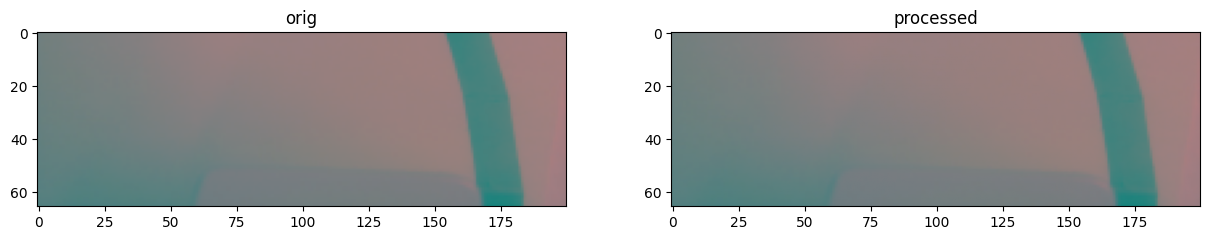

In [9]:
fig, axes = plt.subplots(1,2, figsize=(15,10))
image_orig = imread(image_paths[image_index])
image_processed = image_preprocessing(image_orig)

axes[0].imshow(image_orig)
axes[0].set_title("orig")

axes[1].imshow(image_processed)
axes[1].set_title("processed")

In [10]:
# 자율 주행 모델
def auto_driving():
  # 순차 모델
  model = Sequential(name='ACD_Driving_Model')

  model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='relu'))
  model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='relu'))
  model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3, 3), activation='relu'))

  model.add(Flatten())
  model.add(Dropout(0.2))

  model.add(Dense(100, activation='relu'))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))

  model.add(Dense(1))

  #optimizer = SGD(lr=0.1)
  optimizer = Adam(learning_rate=1e-3)
  model.compile(loss='mse', optimizer=optimizer)

  return model

In [11]:
model = auto_driving()
print(model.summary())

Model: "ACD_Driving_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 dropout (Dropout)           (None, 3, 20, 64)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)        

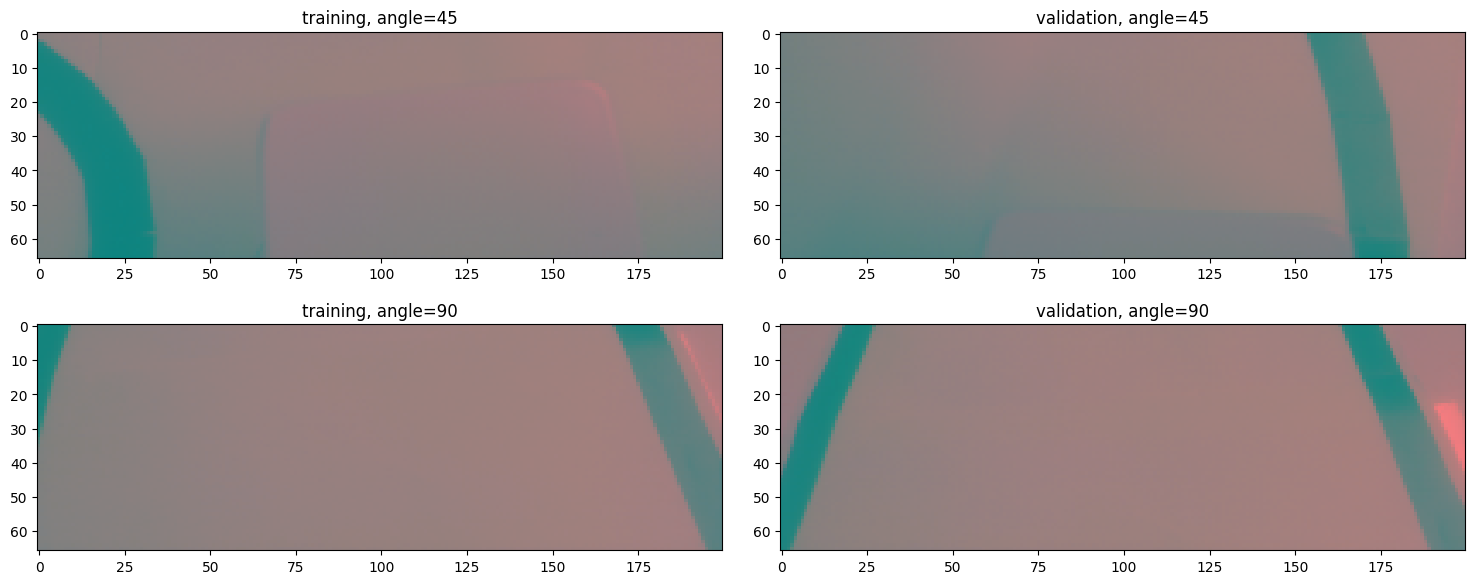

In [12]:
# 학습데이터 생성
def image_data_generator(image_paths, steering_angles, batch_size):
  while True:
    batch_images = []
    batch_steering_angles = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)
      image_path = image_paths[random_index]
      image = imread(image_paths[random_index])
      steering_angle = steering_angles[random_index]

      image = image_preprocessing(image)
      batch_images.append(image)
      batch_steering_angles.append(steering_angle)

    yield(np.asarray(batch_images), np.asarray(batch_steering_angles))

ncol = 2
nrow = 2

x_train_batch, y_train_batch = next(image_data_generator(x_train, y_train, nrow))
x_valid_batch, y_valid_batch = next(image_data_generator(x_valid, y_valid, nrow))

fig, axes = plt.subplots(nrow, ncol, figsize=(15,6))
fig.tight_layout()

for i in range(nrow):
  axes[i][0].imshow(x_train_batch[i])
  axes[i][0].set_title("training, angle=%s" % y_train_batch[i])

  axes[i][1].imshow(x_valid_batch[i])
  axes[i][1].set_title("validation, angle=%s" % y_valid_batch[i])

In [13]:
# 모델 학습
model_output_dir = "/content/drive/MyDrive/졸업작품/자율 주행 모델"

checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir, 'ACD3.h5'), verbose=1, save_best_only=True)


history = model.fit_generator(image_data_generator(x_train, y_train, batch_size=100),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data = image_data_generator(x_valid, y_valid, batch_size=100),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])

model.save(os.path.join(model_output_dir, 'ACD3.h5'))

history_path = os.path.join(model_output_dir, 'ACD3.pickle')

with open(history_path, 'wb') as f:
  pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/10


<ipython-input-13-6bece81285ff>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(image_data_generator(x_train, y_train, batch_size=100),


300/300 [==============================] - ETA: 0s - loss: 1708.4231
Epoch 1: val_loss improved from inf to 1336.36438, saving model to /content/drive/MyDrive/졸업작품/자율 주행 모델/ACD3.h5
300/300 [==============================] - 55s 133ms/step - loss: 1708.4231 - val_loss: 1336.3644
Epoch 2/10
  1/300 [..............................] - ETA: 9s - loss: 1202.2141

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


300/300 [==============================] - ETA: 0s - loss: 1069.9746
Epoch 2: val_loss improved from 1336.36438 to 309.42300, saving model to /content/drive/MyDrive/졸업작품/자율 주행 모델/ACD3.h5
300/300 [==============================] - 38s 129ms/step - loss: 1069.9746 - val_loss: 309.4230
Epoch 3/10
300/300 [==============================] - ETA: 0s - loss: 134.6453
Epoch 3: val_loss improved from 309.42300 to 28.96972, saving model to /content/drive/MyDrive/졸업작품/자율 주행 모델/ACD3.h5
300/300 [==============================] - 45s 150ms/step - loss: 134.6453 - val_loss: 28.9697
Epoch 4/10
300/300 [==============================] - ETA: 0s - loss: 39.8620
Epoch 4: val_loss improved from 28.96972 to 8.41923, saving model to /content/drive/MyDrive/졸업작품/자율 주행 모델/ACD3.h5
300/300 [==============================] - 39s 129ms/step - loss: 39.8620 - val_loss: 8.4192
Epoch 5/10
300/300 [==============================] - ETA: 0s - loss: 25.3862
Epoch 5: val

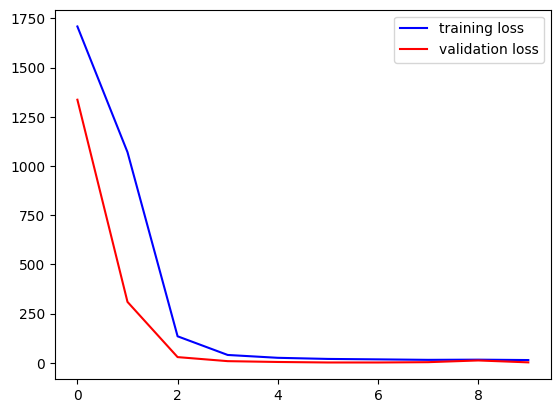

In [14]:
history.history

history_path = os.path.join(model_output_dir,'ACD3.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

history
plt.plot(history['loss'],color='blue')
plt.plot(history['val_loss'],color='red')
plt.legend(["training loss", "validation loss"])

4/4 [==============================] - 0s 5ms/step
mse       = 2.0
r_squared = 99.86%



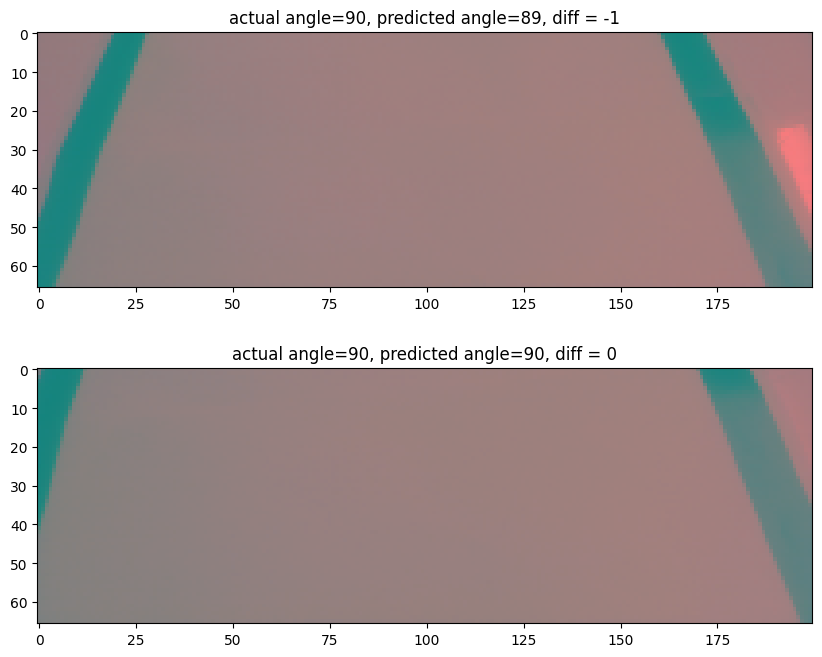

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):

    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)

    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()

def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/ACD3.h5')
    Y_pred = model.predict(X)
    summarize_prediction(Y, Y_pred)
    return Y_pred

n_tests = 100
X_test, y_test = next(image_data_generator(x_valid, y_valid, 100))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 2
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual angle={y_test[i]}, predicted angle={int(y_pred[i])}, diff = {int(y_pred[i])-y_test[i]}")